In [1]:
import sys
import os
import numpy as np
import pandas as pd
import argparse
from pathlib import Path
import glob
import pickle

import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline

import datetime
import imp

sys.path.append('../code')

import data_support
imp.reload(data_support)
from  data_support import get_data


In [2]:
import model
imp.reload(model)
from model import model, fit_model,transform_params,untransform_params

## Plotting functions

In [3]:
def plot_choices(ax,results,state=1,c='k',alpha=0,yoffset=0):

    # get choices and zero out other state (not really relevant)
    choices = np.array(np.array(results['stage2_choices'])).astype('float')
    choices[np.array(results['stage2_states'])==1-state]=np.nan
    
    # get choice probability 
    choice_probs = np.array(results['p_stage2_choices'][:,state-1,1].copy())
    choice_probs_w_nans = choice_probs.copy()
    choice_probs_w_nans[np.array(results['stage2_states'])==1-state]=np.nan
    
    # plot choice prob
    ax.plot(np.arange(len(choice_probs_w_nans)),
            choice_probs_w_nans,
            color=c,
            linestyle='--',
            linewidth=1,
            label=r'$\alpha$='+str(np.round(alpha,1)),
            marker='',ms=3)
             # label = 'p(choice)'

    # plot choices
    choices[choices==0]=choices[choices==0]-yoffset
    choices[choices==1]=choices[choices==1]+yoffset
    ax.scatter(np.arange(len(choices)),
               choices,
               color=c,
               label=None,
               s=2)
    
    # axis stuff 
    ax.set_ylabel('stage 2 choices')
    ax.axhline(y=0.5,linestyle='--',color='k',linewidth=0.5)


In [4]:
def plot_outcomes_and_estimates(ax,results,color1,color2,state=1,include_cvar=True, include_mean=True):
    
    xshift = 0.2; 
    use_ylim = False
    
    # plot means, std, CVaR, outcomes 
    mean1=results['Q_stage2'][:,state-1,0]
    mean2=results['Q_stage2'][:,state-1,1]
    std1=np.sqrt(results['Psi2_stage2'][:,state-1,0])
    std2=np.sqrt(results['Psi2_stage2'][:,state-1,1])
    cvar1=results['Q_stage2_CVaR'][:,state-1,0]
    cvar2=results['Q_stage2_CVaR'][:,state-1,1]
    outcomes = results['outcomes']
    outcomes = np.array(outcomes).astype('float')
    stage2_states = results['stage2_states']
    stage2_choices = results['stage2_choices']
    
    std1 = np.zeros_like(std1)
    std2 = np.zeros_like(std2)
    
    # plot cvar 
    if include_cvar:
        ax.plot(cvar1,color=color1,linewidth=1,linestyle='-',label='CVaR option A')
        ax.plot(cvar2,color=color2,linewidth=1,linestyle='-',label='CVaR option B')
    
    # plot mean / variance
    if include_mean:
        ax.errorbar(np.arange(len(mean1)),
                mean1,
                yerr=std1,
                color=color1,
                linestyle='-.',label=r'$\mu$ option A',linewidth=1,elinewidth=0.5,alpha=1)
        ax.errorbar(np.arange(len(mean1))+xshift,
                mean2,
                yerr=std2,
                color=color2,
                linestyle='-.',label='$\mu$ option B',linewidth=1,elinewidth=0.5,alpha=1)
    
    # (as shading)
    ax.fill_between(np.arange(len(mean1)), y1=mean1,y2=cvar1,alpha=0.05,color=color1)
    ax.fill_between(np.arange(len(mean1)), y1=mean2,y2=cvar2,alpha=0.05,color=color2)
  
    # scaling y-axis 
    ylim = ax.get_ylim()
    if use_ylim:
        mult=ylim[1]*1.1
    else:
        mult=0.95
        
    # plot outcomes choice 0 
    outcomes_tmp = outcomes.copy()
    if state==1:
        outcomes_tmp[np.array(stage2_states)==2]=np.nan
        outcomes_tmp[np.array(stage2_choices)==1]=np.nan
    ax.scatter(np.arange(len(outcomes_tmp)),
                    outcomes_tmp*mult,
               color=color1,label='outcome option A',s=2) # or color_set[0]    

    # plot outcomes choice 1
    outcomes_tmp = outcomes.copy()
    if state==1:
        outcomes_tmp[np.array(stage2_states)==2]=np.nan
        outcomes_tmp[np.array(stage2_choices)==0]=np.nan
    ax.scatter(np.arange(len(outcomes_tmp)),
                    outcomes_tmp*mult,
               color=color2,label='outcome option B',s=2) # or color_set[0]    

    # crossing point 
    first_cross = np.where((cvar1-cvar2)<0)[0][0]
    ax.scatter(first_cross,(cvar1+cvar2)[first_cross]/2,marker='x',s=10,color=color1,zorder=10)

## Run Simulation

In [5]:
# set up simulation 
low_alpha=0.11
med1_alpha=0.3
med2_alpha=0.6
high_alpha=0.99
params = [0.10,50,1,1,0.003,0.5]
param_names = ['alpha', 'beta_stage2', 'beta_MB','beta_MF1','eta','cvar_alpha']

choices = [0,0,0,0,0,0]
outcomes0 = [1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0] # choice 0
outcomes1 = [0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1] # choice 1 
forced_stage2_outcomes = np.zeros((2,2,len(outcomes0))) 
forced_stage2_outcomes[:,0] = outcomes0
forced_stage2_outcomes[:,1] = outcomes1

# run 
generative_results_s = []
for alpha in [low_alpha,med1_alpha,med2_alpha,high_alpha]:
    params[-1]=alpha
    params_t = [transform_params(param,param_name) for param,param_name in zip(params,param_names)]
    generative_results = model(params_t,
                              model_name='dcvar_mb_mf',
                              stage1_choices=None,
                              stage2_choices=None, 
                              stage2_states=None,
                              outcomes=None, 
                              return_nllk=False,
                              generative=True,
                              single_state = True, # restrict self to single second stage state
                              T = len(outcomes0), # only do 20 trials 
                              drifting_probs=None,
                              seed_per_trial=True,
                              forced_stage2_choices = choices,  # pass in stage 2 choices 
                              forced_stage2_outcomes= forced_stage2_outcomes, # pass in outcomes 
                              force_outcomes_until = len(outcomes0),
                              force_choices_until = len(choices),
                              deterministic_2nd_choice=True,
                               init_Psi2=0.03,
                              )
    generative_results_s.append(generative_results)
    
generative_results_low = generative_results_s[0]
generative_results_med1 = generative_results_s[1]
generative_results_med2 = generative_results_s[2]
generative_results_high = generative_results_s[3]

In [6]:
color_palette = sns.color_palette("brg",15)
color_low = color_palette[7]
color_med1 = color_palette[5]
color_med2 = color_palette[2]
color_high = color_palette[0]

## Plot

Text(13, 0.45, 'mean A')

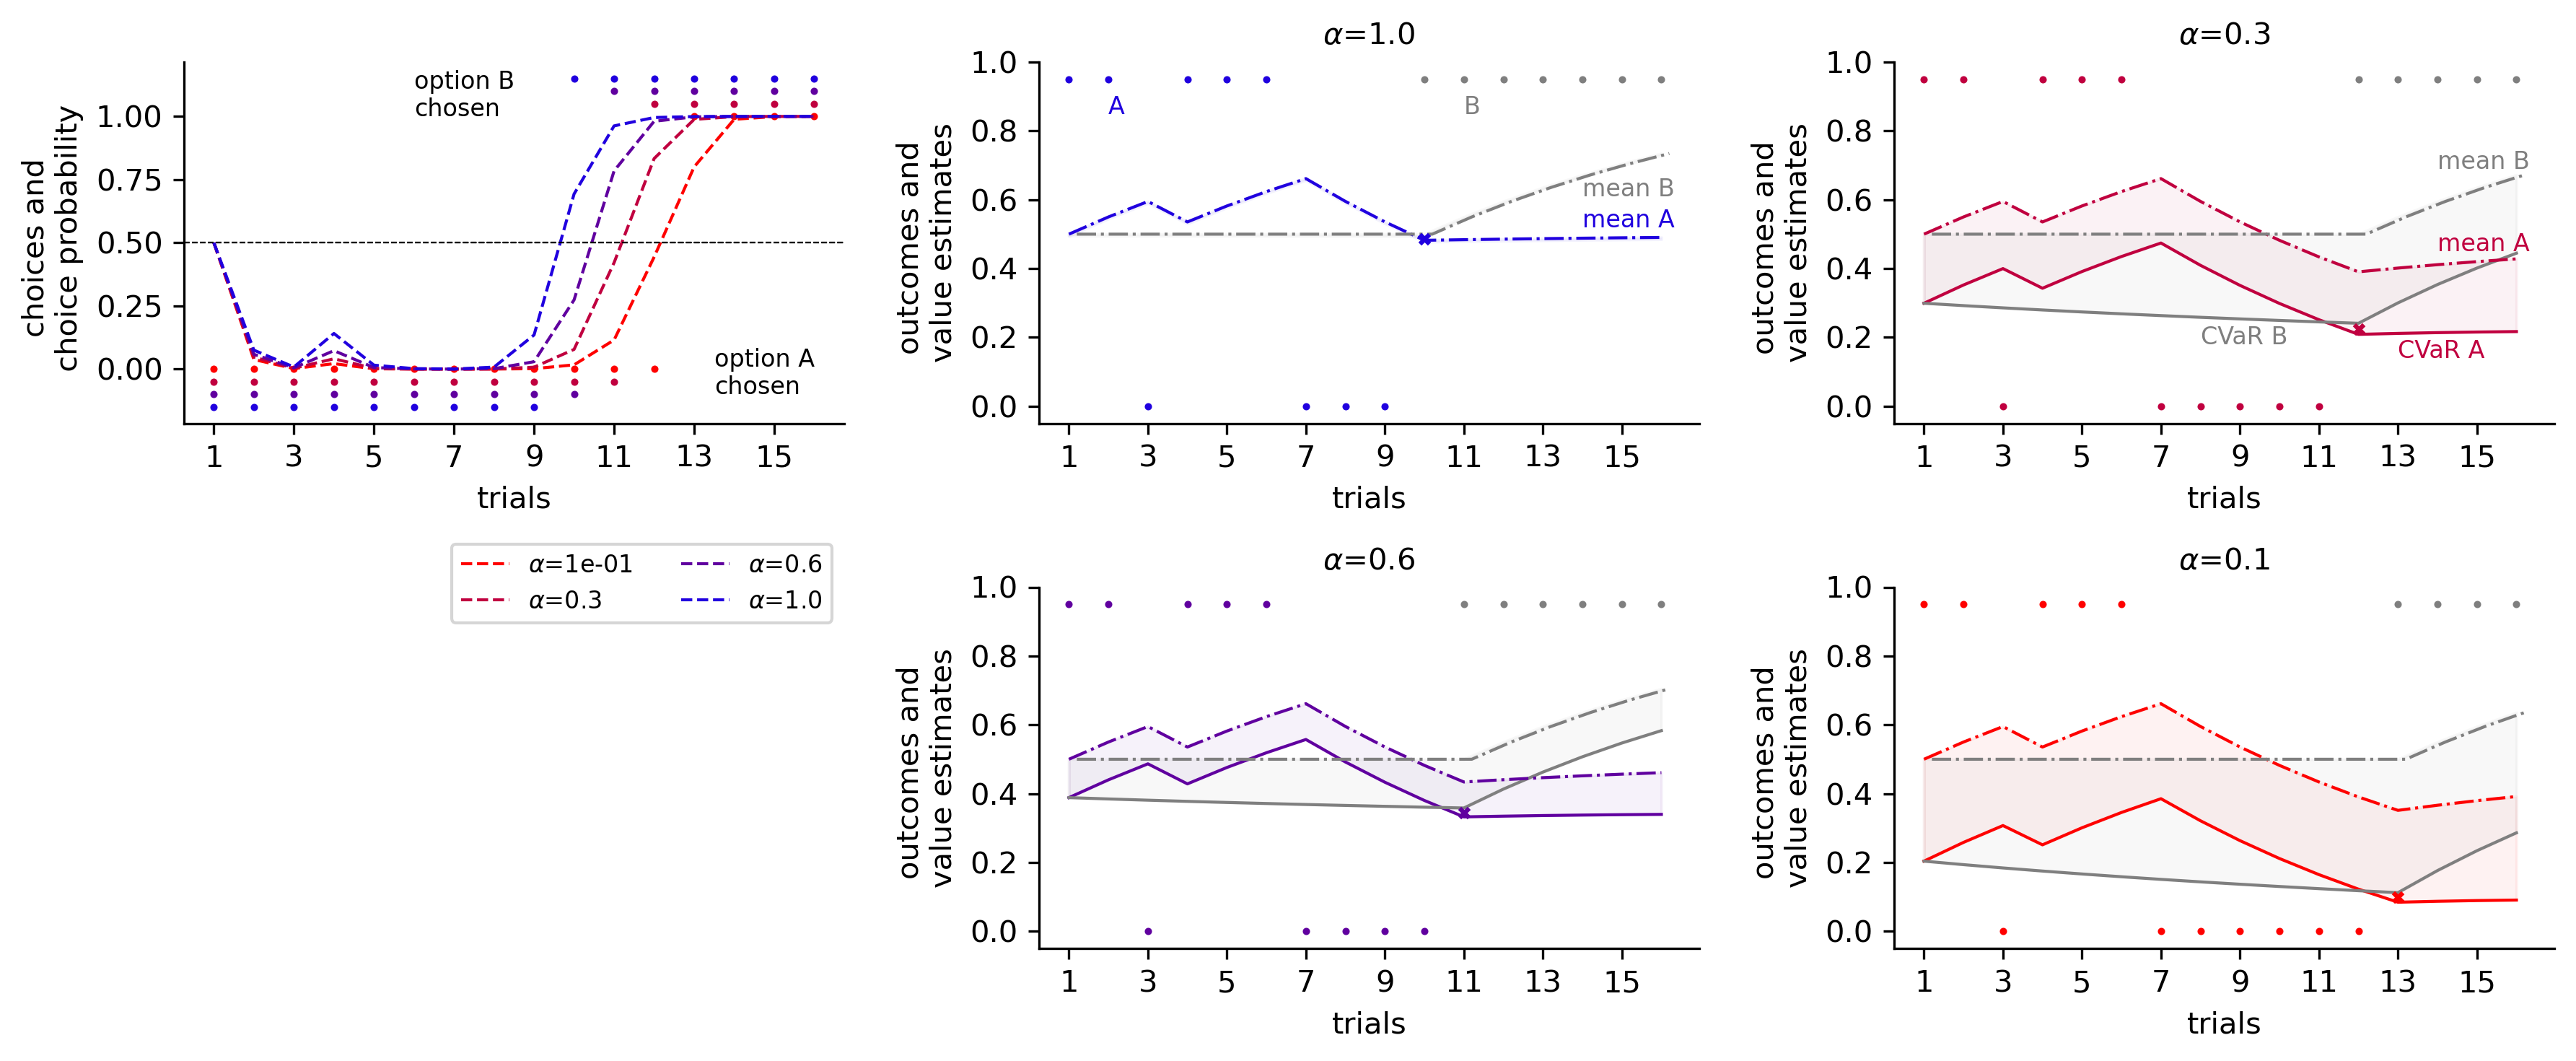

In [7]:
## plotting simulation ## 
fs = 10
figsize=(12,5)
fig,axes = plt.subplots(2,3,figsize=figsize,dpi=300)
ax_choices = axes[0,0]
ax_low = axes[1,2]
ax_med2 = axes[1,1]
ax_med1 = axes[0,2]
ax_high = axes[0,1]
ax_empty = axes[1,0]

upper=1.0
lower=-0.05
ax_low.set_ylim([lower,upper])
ax_med1.set_ylim([lower,upper])
ax_med2.set_ylim([lower,upper])
ax_high.set_ylim([lower,upper])

# plotting choices 
plot_choices(ax_choices,generative_results_low,state=1,c=color_low,yoffset=0,alpha=low_alpha)
plot_choices(ax_choices,generative_results_med1,state=1,c=color_med1,yoffset=0.05,alpha=med1_alpha)
plot_choices(ax_choices,generative_results_med2,state=1,c=color_med2,yoffset=0.1,alpha=med2_alpha)
plot_choices(ax_choices,generative_results_high,state=1,c=color_high,yoffset=0.15,alpha=high_alpha)

# plotting outcomes and estimates=
plot_outcomes_and_estimates(ax_low,generative_results_low,color1=color_low,color2=sns.color_palette()[7],state=1)
plot_outcomes_and_estimates(ax_med1,generative_results_med1,color1=color_med1,color2=sns.color_palette()[7],state=1)
plot_outcomes_and_estimates(ax_med2,generative_results_med2,color1=color_med2,color2=sns.color_palette()[7],state=1)
plot_outcomes_and_estimates(ax_high,generative_results_high,color1=color_high,color2=sns.color_palette()[7],state=1,include_cvar=False)

ax_low.set_title(r'$\alpha$='+str(np.round(low_alpha,1)),fontsize=fs)
ax_med1.set_title(r'$\alpha$='+str(med1_alpha),fontsize=fs)
ax_med2.set_title(r'$\alpha$='+str(med2_alpha),fontsize=fs)
ax_high.set_title(r'$\alpha$='+str(np.round(high_alpha,1)),fontsize=fs)

ylabel='outcomes and \nvalue estimates'
ax_low.set_ylabel(ylabel,fontsize=fs)
ax_med1.set_ylabel(ylabel,fontsize=fs)
ax_med2.set_ylabel(ylabel,fontsize=fs)
ax_high.set_ylabel(ylabel,fontsize=fs)

ax_choices.set_ylabel('choices and \n choice probability',fontsize=fs)

for ax in axes.flatten():
    plt.sca(ax)
    plt.xlabel('trials')
    xticks=np.arange(1,len(outcomes0)+1,2)
    plt.xticks(xticks-1,xticks,fontsize=fs)
    sns.despine()
    
# shared
plt.tight_layout()
    
plt.sca(ax_empty)
plt.xticks([])
plt.yticks([])
plt.axis('off')

# add legends
plt.sca(ax_choices)
plt.legend(bbox_to_anchor=(1.0,-0.30),ncol=2,fontsize=fs-2)
plt.annotate('option B\nchosen',(5,1.0),fontsize=fs-2)
plt.annotate('option A\nchosen',(12.5,-0.1),fontsize=fs-2)

plt.sca(ax_high)
plt.annotate('A',(1,0.85),fontsize=fs-2,color=color_high)
plt.annotate('B',(10,0.85),fontsize=fs-2,color=sns.color_palette()[7])
plt.annotate(r'mean B',(13,0.61),fontsize=fs-2,color=sns.color_palette()[7])
plt.annotate(r'mean A',(13,0.52),fontsize=fs-2,color=color_high)

plt.sca(ax_med1)
plt.annotate(r'CVaR B',(7,0.18),fontsize=fs-2,color=sns.color_palette()[7])
plt.annotate(r'CVaR A',(12,0.14),fontsize=fs-2,color=color_med1)
plt.annotate(r'mean B',(13,0.69),fontsize=fs-2,color=sns.color_palette()[7])
plt.annotate(r'mean A',(13,0.45),fontsize=fs-2,color=color_med1)